## Librairies

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

We consolidated the preprocessing functionality into a single class named Data, which provides methods for:

    - Reading data from a file into a Pandas DataFrame.
    - Creating features essential for subsequent model development.
    - Scaling the data for use in the model.
 

In [3]:
class Data:
    def __init__(self, path ):
        self.path = path
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def read_data(self):
        """Read data and return a data frame"""
        df = pd.read_csv(self.path)
        df = df.set_index("DATE")
        df.index = pd.to_datetime(df.index)
        return df
            
        # Create supervised learning data (sliding window)
    def create_supervised(self,data, lag=1):
        X, y = [], []
        for i in range(len(data) - lag):
            X.append(data[i:i + lag])
            y.append(data[i + lag])
        return np.array(X), np.array(y)
    
    def create_features(self,df, att):
        """Create time series features based  on time series index"""
        values = df[att].values.reshape(-1, 1)
        # Scale the data using MinMaxScaler
        scaled_data = self.scaler.fit_transform(values)
        # Use a lag of 12 (for example)
        lag = 12
        X, y = self.create_supervised(scaled_data, lag)
        return X, y
    


In [5]:
path = "../data/IPG2211A2N.csv"
data = Data(path)
df = data.read_data()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
IPG2211A2N,1030.0,56.821588,35.982935,3.3336,20.968675,56.9096,89.5908,126.3772


In [6]:
df.isnull().sum()

IPG2211A2N    0
dtype: int64

<Axes: title={'center': 'IPG2211A2N PRODUCTION'}, xlabel='DATE'>

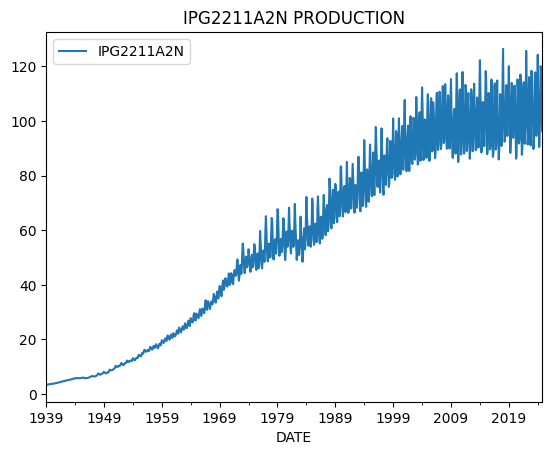

In [7]:
df[['IPG2211A2N']].plot(title='IPG2211A2N PRODUCTION')

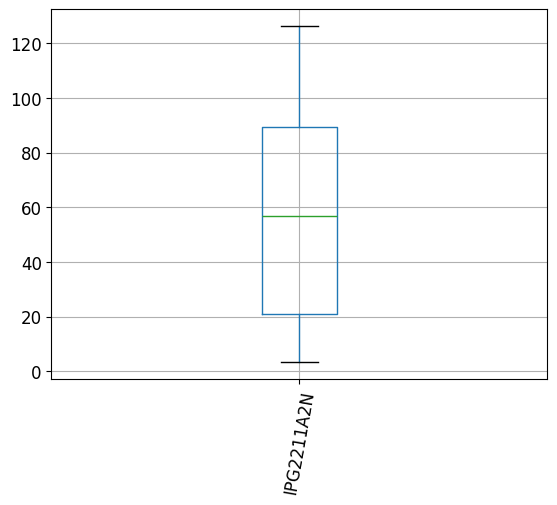

In [8]:
df.boxplot('IPG2211A2N', rot = 80, fontsize = '12',grid = True);

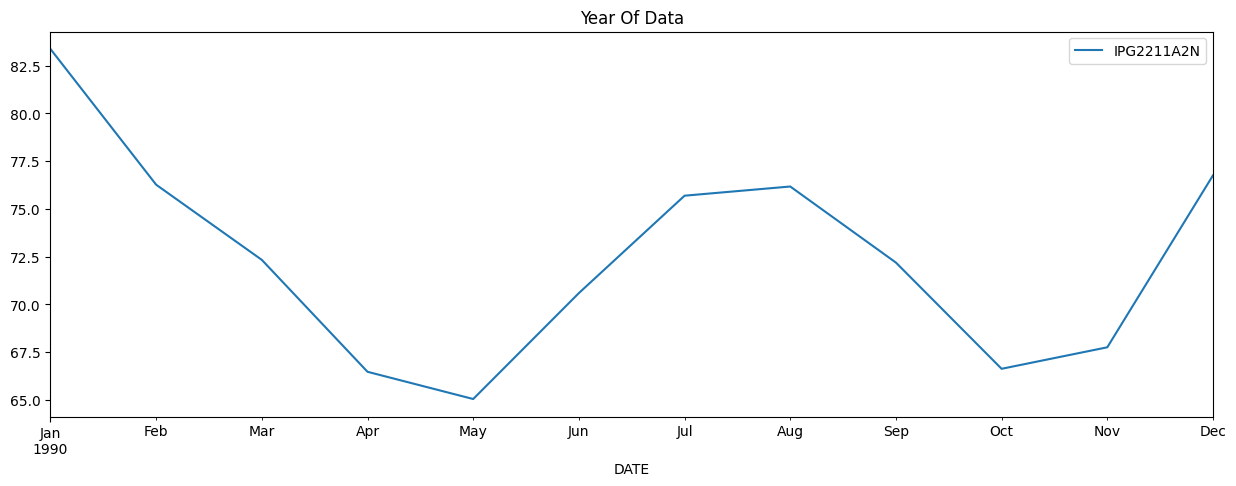

In [9]:
df.loc[(df.index >= '1990-01-01') & (df.index < '1991-01-01')] \
    .plot(figsize=(15, 5), title='Year Of Data')
plt.show()

This plot reveals a seasonal pattern, with production values peaking during winter months (e.g., January and December) and summer months (e.g., July and August). The diagram below provides further confirmation of this trend.

Text(0.5, 1.0, 'IP per month')

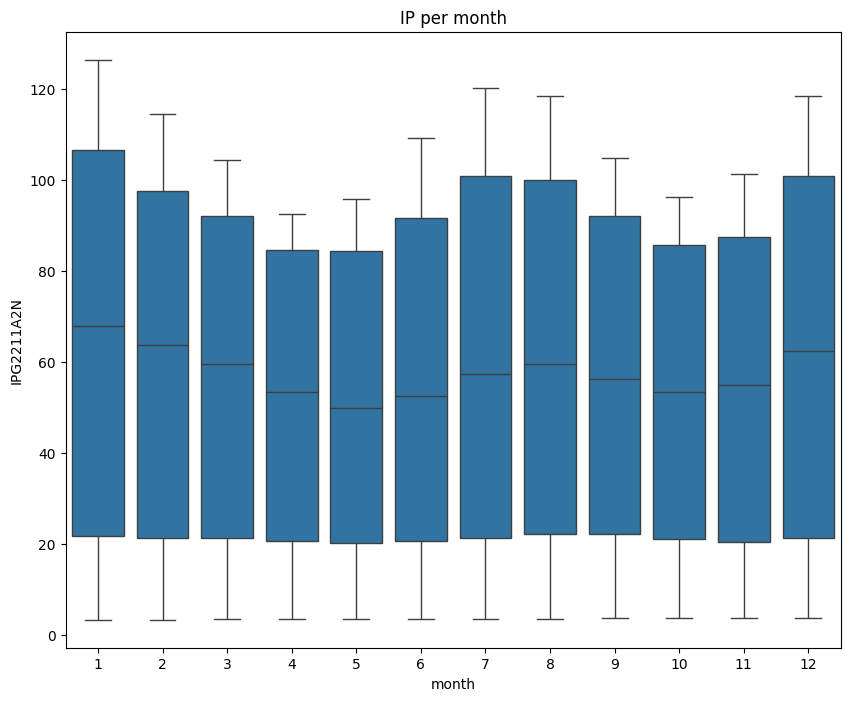

In [10]:
fig, ax = plt.subplots(figsize = (10,8))
df2 = df.copy()
df2["month"] = df2.index.month
sns.boxplot(data=df2[["month","IPG2211A2N"]], x ="month", y ="IPG2211A2N" )
ax.set_title("IP per month")

The boxplot confirms our previous assumption. Given the observed seasonality, it is crucial to incorporate the last 12 values (corresponding to the previous year) as additional attributes.

In [ ]:
X, y = data.create_features(df ,'IPG2211A2N' )
# Split into training and testing sets
split_index = int(len(X) * 0.8)  # Use 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Check the shapes of the datasets before reshaping for LSTM
print(f"X_train shape before reshape: {X_train.shape}, X_test shape before reshape: {X_test.shape}")

# Reshape input data for LSTM (3D shape: [samples, time_steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adding '1' as the number of features
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Check the shapes after reshaping
print(f"X_train shape after reshape: {X_train.shape}, X_test shape after reshape: {X_test.shape}")


X_train shape before reshape: (814, 12, 1), X_test shape before reshape: (204, 12, 1)
X_train shape after reshape: (814, 12, 1), X_test shape after reshape: (204, 12, 1)
